In [ ]:
import pandas as pd
import numpy as np
import gzip
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.callbacks import Callback

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("galaxyh/kdd-cup-1999-data")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/kdd-cup-1999-data


In [ ]:
import pandas as pd
import gzip

# Full path to file (adjust path if needed)
file_path = path + "/kddcup.data_10_percent.gz"

# Read the compressed file
with gzip.open(file_path, 'rt') as f:
    df = pd.read_csv(f, header=None)

In [ ]:
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins",
    "logged_in", "num_compromised", "root_shell", "su_attempted",
    "num_root", "num_file_creations", "num_shells", "num_access_files",
    "num_outbound_cmds", "is_host_login", "is_guest_login", "count",
    "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate",
    "srv_rerror_rate", "same_srv_rate", "diff_srv_rate",
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]
df.columns = columns

In [ ]:
df['binary_label'] = df['label'].apply(lambda x: 0 if x == 'normal.' else 1)

# Encode categorical features
categorical_cols = ['protocol_type', 'service', 'flag']
le_dict = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    le_dict[col] = le

# Scale the features
features = df.drop(columns=['label', 'binary_label'])
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(features)


In [ ]:
#auto encoder method
normal_data = data_scaled[df['binary_label'] == 0]

# Build Autoencoder
input_dim = normal_data.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)
encoded = Dense(16, activation='relu')(encoded)
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Accuracy tracking callback
class AccuracyCallback(Callback):
    def __init__(self, full_data, binary_labels, threshold):
        super().__init__()
        self.full_data = full_data
        self.binary_labels = binary_labels
        self.threshold = threshold

    def on_epoch_end(self, epoch, logs=None):
        recon = self.model.predict(self.full_data, verbose=0)
        mse = np.mean(np.power(self.full_data - recon, 2), axis=1)
        preds = (mse > self.threshold).astype(int)
        acc = accuracy_score(self.binary_labels, preds)
        print(f" - val_accuracy: {acc:.4f}")

# Fit once to get threshold
recon = autoencoder.predict(normal_data)
mse_train = np.mean(np.power(normal_data - recon, 2), axis=1)
threshold = np.percentile(mse_train, 95)

# Train with callback
callback = AccuracyCallback(data_scaled, df['binary_label'].values, threshold)
history = autoencoder.fit(normal_data, normal_data, epochs=20, batch_size=256, shuffle=True, callbacks=[callback])

# Final prediction
auto_recon = autoencoder.predict(data_scaled)
auto_mse = np.mean(np.power(data_scaled - auto_recon, 2), axis=1)
df['auto_pred'] = (auto_mse > threshold).astype(int)
auto_acc = accuracy_score(df['binary_label'], df['auto_pred'])
print("\n🎯 Autoencoder Final Accuracy:", auto_acc)


3040/3040 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Epoch 1/20
376/380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0920 - val_accuracy: 0.1969
380/380 ━━━━━━━━━━━━━━━━━━━━ 46s 116ms/step - loss: 0.0913
Epoch 2/20
354/380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0045 - val_accuracy: 0.1969
380/380 ━━━━━━━━━━━━━━━━━━━━ 81s 114ms/step - loss: 0.0044
Epoch 3/20
379/380 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0019 - val_accuracy: 0.1969
380/380 ━━━━━━━━━━━━━━━━━━━━ 83s 116ms/step - loss: 0.0019
Epoch 4/20
364/380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0013 - val_accuracy: 0.1969
380/380 ━━━━━━━━━━━━━━━━━━━━ 66s 73ms/step - loss: 0.0013
Epoch 5/20
377/380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0010 - val_accuracy: 0.1969
380/380 ━━━━━━━━━━━━━━━━━━━━ 43s 115ms/step - loss: 0.0010
Epoch 6/20
369/380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8.5098e-04 - val_accuracy: 0.1969
380/380 ━━━━━━━━━━━━━━━━━━━━ 28s 73ms/step - loss: 8.4995e-04
Epoch 7/20
372/380 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

In [ ]:
iso_model = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso_model.fit(data_scaled)

# Predict: -1 (anomaly), 1 (normal)
df['iso_pred'] = iso_model.predict(data_scaled)
df['iso_pred'] = df['iso_pred'].map({1: 0, -1: 1})  # Convert to 0/1
iso_acc = accuracy_score(df['binary_label'], df['iso_pred'])
print("\n🎯 Isolation Forest Final Accuracy:", iso_acc)



🎯 Isolation Forest Final Accuracy: 0.21895020657016603


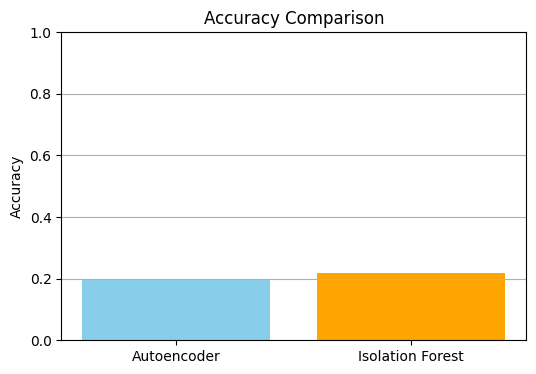

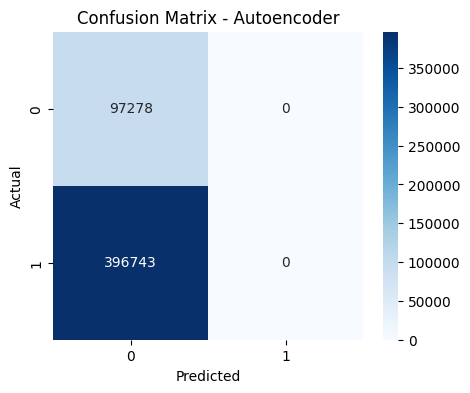

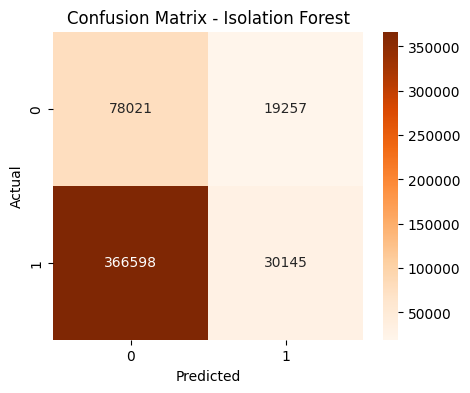

In [ ]:
plt.figure(figsize=(6, 4))
plt.bar(['Autoencoder', 'Isolation Forest'], [auto_acc, iso_acc], color=['skyblue', 'orange'])
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(axis='y')
plt.show()

# Confusion Matrix for Autoencoder
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(df['binary_label'], df['auto_pred']), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Autoencoder')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Confusion Matrix for Isolation Forest
plt.figure(figsize=(5, 4))
sns.heatmap(confusion_matrix(df['binary_label'], df['iso_pred']), annot=True, fmt='d', cmap='Oranges')
plt.title('Confusion Matrix - Isolation Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
print("\n📊 Classification Report - Autoencoder")
print(classification_report(df['binary_label'], df['auto_pred']))

print("\n📊 Classification Report - Isolation Forest")
print(classification_report(df['binary_label'], df['iso_pred']))



📊 Classification Report - Autoencoder
              precision    recall  f1-score   support

           0       0.20      1.00      0.33     97278
           1       0.00      0.00      0.00    396743

    accuracy                           0.20    494021
   macro avg       0.10      0.50      0.16    494021
weighted avg       0.04      0.20      0.06    494021


📊 Classification Report - Isolation Forest
              precision    recall  f1-score   support

           0       0.18      0.80      0.29     97278
           1       0.61      0.08      0.14    396743

    accuracy                           0.22    494021
   macro avg       0.39      0.44      0.21    494021
weighted avg       0.52      0.22      0.17    494021



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
